In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import pandas as pd
import os
import mpu
import torch
import transformers
import platform

print(torch.__version__) # checking pytorch version 2.0 or more
print(platform.mac_ver()) # checking pytorch version for mac - should be arm64
print(transformers.__version__) # checking transformers version
print(torch.backends.mps.is_built()) # checking if mps is available   
device = torch.device('mps') # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

2.4.0.dev20240317
('14.4.1', ('', '', ''), 'arm64')
4.39.3
True
mps


# read data

In [3]:
d_tokenized = mpu.io.read('../data/d_tokenized.pickle')
class_weights = mpu.io.read('../data/class_weights.pickle')

print(d_tokenized, class_weights)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 4015
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1004
    })
}) tensor([0.0124, 0.9876], device='mps:0')


# train model

In [8]:
# xlm-roberta model

import torch.nn.functional as nn
from transformers import (AutoModelForSequenceClassification, AutoTokenizer)

id2label = {0: 'negative', 
            1: 'positive'}
label2id = {'negative':0, 
            'positive':1}

model = AutoModelForSequenceClassification.from_pretrained('xlm-roberta-base', 
                                                           num_labels=2, 
                                                           id2label=id2label, 
                                                           label2id=label2id).to(device)

tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

# freeze transformer model parametres

for param in model.base_model.parameters():
    param.requires_grad = False

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# create a costum Trainer class with weighted loos function 

from torch import nn
from transformers import Trainer

class WeightedLossTrainer(Trainer):
    
    def compute_loss(self, model, inputs, return_outputs=False):
        
        # feed inputs to model and extract logits
        outputs = model(**inputs)
        logits = outputs.get("logits")
        
        # extract labels
        labels = inputs.get("labels")
        
        # define loss function with class weight
        loss_function = nn.CrossEntropyLoss(weight=class_weights)
        
        # compute loss
        loss = loss_function(logits, labels)
        
        return (loss, outputs) if return_outputs else loss

In [11]:
from transformers import TrainingArguments
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

batch_size = 16
epochs = 8

#log the training loss at each epoch
logging_steps = len(d_tokenized['train']['text']) // batch_size

output_dir = "../results/transformer_trainer/"

training_args = TrainingArguments(output_dir=output_dir,
                                 num_train_epochs=epochs,
                                 learning_rate=1e-3,
                                 per_device_train_batch_size=batch_size,
                                 per_device_eval_batch_size=batch_size,
                                 weight_decay=0.01,
                                 evaluation_strategy="epoch", # evaluatoion strategy is computed after each epoch
                                 logging_steps=logging_steps)

In [12]:
# function to compute metrics at evaluation

from sklearn.metrics import f1_score, recall_score, precision_score

def compute_metrics(pred):
    
    # extract label and predictions
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    # calculate metrics
    f1 = f1_score(labels, preds)
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    
    return {"f1": f1,
           "precision": precision,
           "recall": recall}

In [ ]:
# from transformers import TrainerCallback

# class EpochCallback(TrainerCallback):
#     def on_epoch_begin(self, args, state, control, **kwargs):
#         best = state.best_metric
#         print("yo, epoch begin")
#         print("best metric so far" + str(best))

In [13]:
# instantiate trainer

trainer1 = WeightedLossTrainer(model=model,
                             args=training_args,
                             compute_metrics=compute_metrics,
                             train_dataset=d_tokenized['train'],
                             eval_dataset=d_tokenized['test'],                     
                             tokenizer=tokenizer,
                             data_collator=data_collator
#                              callbacks=[EpochCallback]
                             )

/Users/uqvberde/Library/Python/3.11/lib/python/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [16]:
%%time

torch.manual_seed(42)

results_1 = trainer1.train()

Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,1.398800,1.378771,0.000000,0.000000,0.000000
2,1.257600,0.993298,0.000000,0.000000,0.000000
3,1.205700,1.113581,0.000000,0.000000,0.000000
4,1.185100,1.275612,0.000000,0.000000,0.000000
5,1.080900,1.167612,0.000000,0.000000,0.000000
6,1.090900,1.261458,0.000000,0.000000,0.000000
7,1.112500,1.066257,0.000000,0.000000,0.000000
8,1.005500,1.054309,0.000000,0.000000,0.000000


/Users/uqvberde/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/uqvberde/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/uqvberde/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/uqvberde/Library/Python/3.11/lib/python/site-packages/skl

CPU times: user 1min 1s, sys: 25.4 s, total: 1min 26s
Wall time: 24min 7s


In [17]:
preds_output = trainer1.predict(d_tokenized['test'])
preds_output.metrics

/Users/uqvberde/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'test_loss': 1.0543087720870972,
 'test_f1': 0.0,
 'test_precision': 0.0,
 'test_recall': 0.0,
 'test_runtime': 29.2852,
 'test_samples_per_second': 34.284,
 'test_steps_per_second': 2.151}

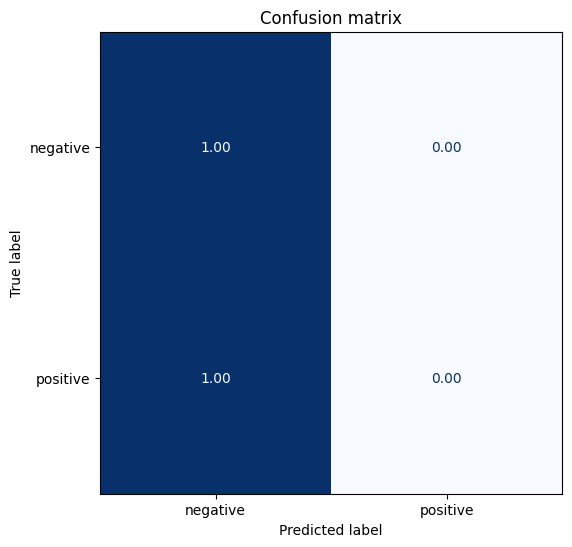

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

labels = ['negative', 'positive']

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize='true')
    fig, ax =plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f',ax=ax,colorbar=False)
    plt.title('Confusion matrix')
    plt.show()

y_preds = np.argmax(preds_output.predictions, axis=1)

plot_confusion_matrix(y_preds, d_tokenized['test']['label'], labels)

In [ ]:
mpu.io.write('../results/transformer_trainer/results_2.pickle', results_1)
mpu.io.write('../results/transformer_trainer/trainer2.pickle', trainer1)

In [ ]:
# from sklearn.metrics import confusion_matrix

# confusion_matrix(d_tokenized['train']['labels'], preds)

In [ ]:
torch.manual_seed(42)

trainer2 = WeightedLossTrainer(model=model,
                             args=training_args,
                             compute_metrics=compute_metrics,
                             train_dataset=d_tokenized['train'],
                             eval_dataset=d_tokenized['test'],                     
                             tokenizer=tokenizer,
                             data_collator=data_collator
#                              callbacks=[EpochCallback]
                             )
results_2 = trainer2.train()